# **Protein Amino Acid Sequence Similarity**

### Install required libraries

In [ ]:
!pip install rdkit
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install DeepPurpose
!pip install Bio
!pip install PySpark
!pip install wget

### Import required libraries

In [109]:
from DeepPurpose import DTI as modelsdti
from DeepPurpose import PPI as modelsppi
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
from DeepPurpose import dataset, CompoundPred, utils, encoders

import Bio
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import time
import random
import csv
import os
import wget

import multiprocessing
from multiprocessing import pool

import matplotlib.pyplot as plt

#### **What is DeepPurpose Library**

##### DeepPurpose is a deep learning library specifically designed for drug discovery and drug repurposing tasks. It provides a wide range of functionalities and tools for various aspects of drug discovery, including target prediction, drug-target interaction prediction, and virtual screening.

<br/>

##### DeepPurpose leverages deep learning models such as graph convolutional neural networks (GCN) and recurrent neural networks (RNN) to learn representations of molecular structures and predict their properties. It incorporates both sequence-based and graph-based approaches to handle different types of molecular data.

<br/>

##### Some of the key features of DeepPurpose include: Drug-Target Interaction Prediction, Compound Property Prediction, Protein-Protein Interaction Prediction, and Protein Function prediction (using PyTorch).

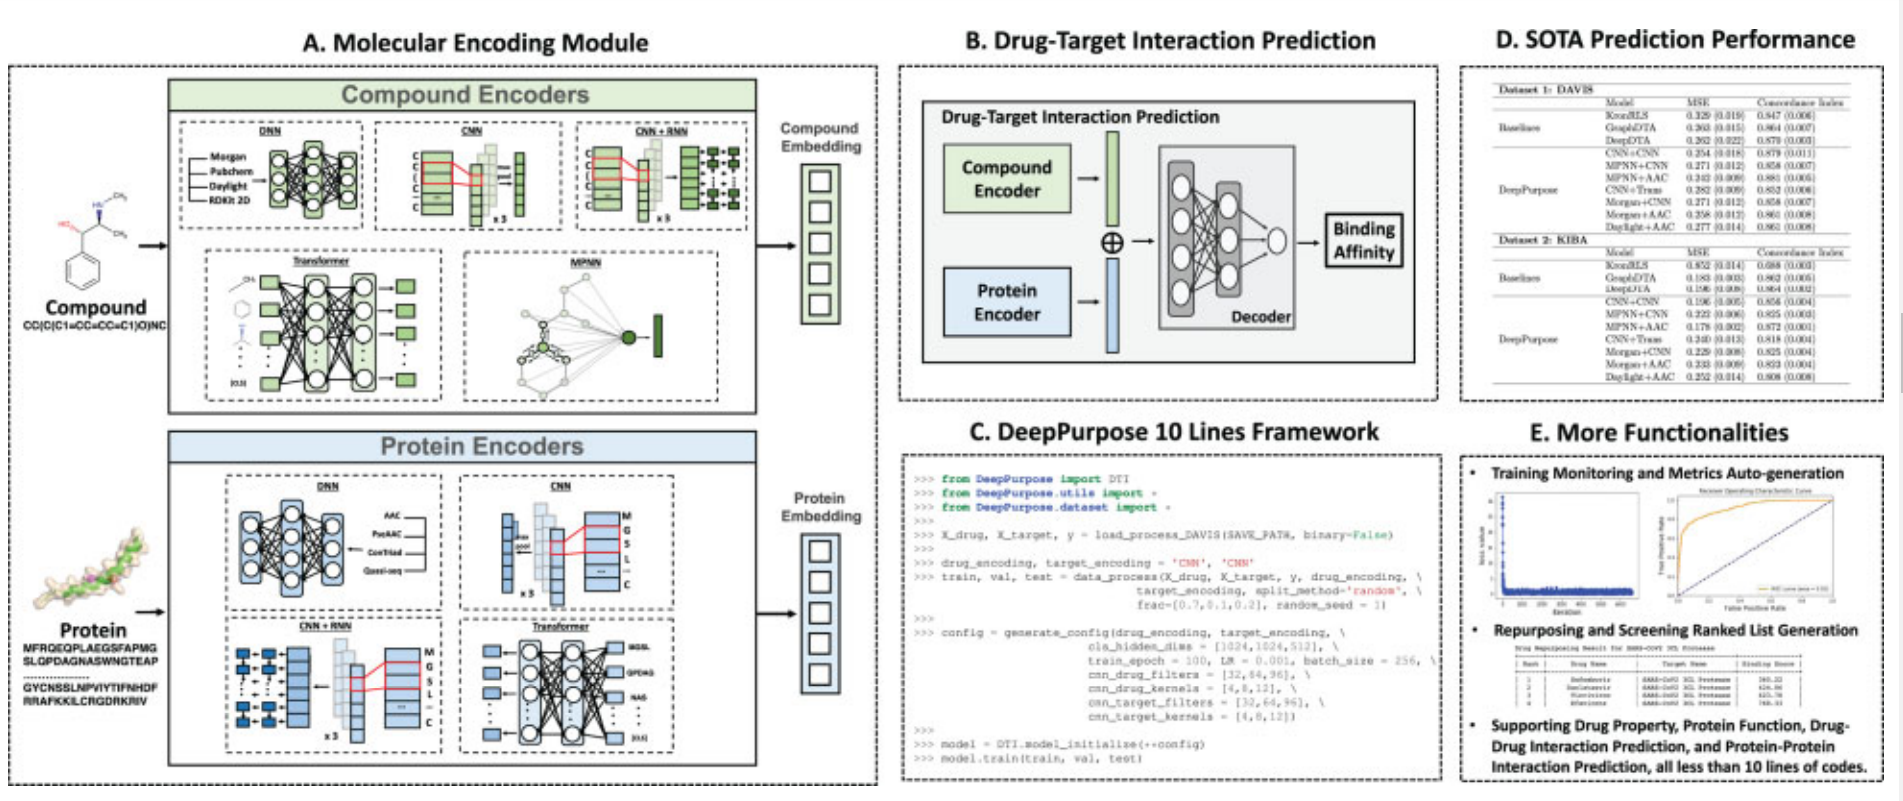



Image Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8016467/pdf/btaa1005.pdf

Fig. 1. Overview of DeepPurpose library. (A) DeepPurpose takes as input the SMILES of a compound and a protein’s amino acid sequence and then generates embeddings for
them. (B) The learned embeddings are then concatenated and fed into a decoder to predict DTI binding affinity. (C) DeepPurpose provides a simple but flexible programming
framework that implements over 50 state-of-the-art DL models for DTI prediction. (D) DeepPurpose models achieve comparable performance with three other DTI prediction
algorithms on two benchmark datasets. (E) Finally, DeepPurpose has many functionalities, including monitoring the training process, debugging and generation ranked lists
for repurposing and screening. Further, DeepPurpose supports other downstream prediction tasks (e.g. drug–drug interaction prediction, compound property prediction)

#### **Protein Sequence Similarity**

##### DeepPurpose doesn't provide protein to protein amino acid sequence similarity.

<br/>

##### Protein to Protein sequence similarity allows researchers to infer functional and evolutionary relationships between proteins.

<br/>

##### One of the key challenges in drug discovery is identifying target proteins that are involved in a particular disease pathway and that can be effectively modulated by a drug compound.

<br/>

##### Protein sequence pairwise similarity can help identify potential drug targets by comparing the amino acid sequences of proteins involved in disease pathways to those of known drug targets. If a high level of similarity is found between a disease-associated protein and a known drug target, it may suggest that the protein could be a promising target for drug development.

<br/>

##### Furthermore, protein sequence pairwise similarity can also be used to identify potential off-target effects of a drug compound. By comparing the amino acid sequence of a drug target to other proteins in humans, researchers can identify proteins that are similar to the target and may be affected by the drug. This information can be used to guide drug design and optimize drug specificity.

<br/>

##### Overall, protein sequence pairwise similarity is a powerful tool that can be used to aid in the identification and characterization of drug targets, as well as to optimize drug design and minimize off-target effects.

<br/>

##### ***Since DeepPurpose have drug and protien encoders, we will utilize DeepPurpose protien encoders to encode our protein data and then create a model to calculate the similarity scores***
<br/>

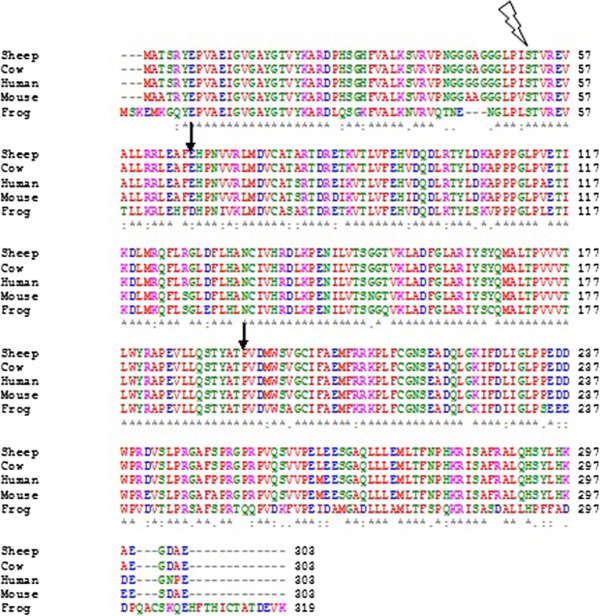

Image Source: https://www.wikiwand.com/en/Clustal

### **DeepPurose Demo of Protein to Protein Prediciton using affinity scores**

##### DeepPurpose measures Protein to Protein prediciton and protein function using affinity scores, also known as binding scores. Protein affinity scores, or binding affinity scores, are like a measuring tape that tells us how strong two molecules are attracted to each other. These two molecules are usually a protein and a ligand.

<br/>

##### The score itself is a way to measure how much the two molecules like each other, and it's usually expressed as a number called a dissociation constant or Kd. The Kd value represents the amount of the ligand needed to occupy half of the available binding sites on the protein. The lower the Kd value, the stronger the attraction between the protein and the ligand.

<br/>

##### Protein affinity scores are super important in lots of different fields of research. For example, in drug discovery and development, scientists use these scores to figure out whether a new compound will work well by seeing how well it binds to a specific protein. In biochemistry and molecular biology, these scores help us understand how proteins and ligands interact with each other, and how different proteins interact with each other in complex biological systems.

<br/>

##### The drug-target interaction affinities published by [Davis et al (2011) ](http://dx.doi.org/10.1038/nbt.1990)

<br/>

In [3]:
# Download the affinity scores file

!wget -P /content http://staff.cs.utu.fi/~aatapa/data/DrugTarget/drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt

--2023-05-09 15:31:40--  http://staff.cs.utu.fi/~aatapa/data/DrugTarget/drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt
Resolving staff.cs.utu.fi (staff.cs.utu.fi)... 130.232.251.137
Connecting to staff.cs.utu.fi (staff.cs.utu.fi)|130.232.251.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164306 (160K) [text/plain]
Saving to: ‘/content/drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt’

drug-target_interac 100%[===================>] 160.46K   230KB/s    in 0.7s    

2023-05-09 15:31:42 (230 KB/s) - ‘/content/drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt’ saved [164306/164306]



In [33]:
# load DB Binary Data
X_targets, X_targets_, y = read_file_training_dataset_protein_protein_pairs("/content/drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt")

In [34]:
# encode and preprocess data

target_encoding = 'CNN'
train, val, test = data_process(X_target = X_targets, X_target_ = X_targets_, y = y, 
			    target_encoding = target_encoding,
			    split_method='random', 
			    random_seed = 1)

config = generate_config(target_encoding = target_encoding, 
                         cls_hidden_dims = [512], 
                         train_epoch = 20, 
                         LR = 0.001, 
                         batch_size = 128,
                        )

Protein Protein Interaction Prediction Mode...
in total: 68 protein-protein pairs
encoding protein...
unique target sequence: 27
encoding protein...
unique target sequence: 34
Done.


Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 6149076. Total time 0.0 hours
Validation at Epoch 1 , MSE: 6107819 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 2 iteration 0 with loss 6148849. Total time 0.0 hours
Validation at Epoch 2 , MSE: 6107616 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 3 iteration 0 with loss 6148648. Total time 0.0 hours
Validation at Epoch 3 , MSE: 6107377 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 4 iteration 0 with loss 6148406. Total time 0.0 hours
Validation at Epoch 4 , MSE: 6107043 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 5 iteration 0 with loss 6148072. Total time 0.0 hours
Validation at Epoch 5 , MSE: 6106546 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 6 iteration 0 with loss 6147580. Total time 0.0 hours
Validation at Epoch 6 , MSE: 6105806 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 7 iteration 0 with loss 6146856. Total time 0.00027 hours
Validation at Epoch 7 , MSE: 6104706 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 8 iteration 0 with loss 6145773. Total time 0.00027 hours
Validation at Epoch 8 , MSE: 6103103 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 9 iteration 0 with loss 6144109. Total time 0.00027 hours
Validation at Epoch 9 , MSE: 6100812 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 10 iteration 0 with loss 6141804. Total time 0.00027 hours
Validation at Epoch 10 , MSE: 6097586 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 11 iteration 0 with loss 6138641. Total time 0.00027 hours
Validation at Epoch 11 , MSE: 6093108 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 12 iteration 0 with loss 6134065. Total time 0.00027 hours
Validation at Epoch 12 , MSE: 6086988 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 13 iteration 0 with loss 6128147. Total time 0.00055 hours
Validation at Epoch 13 , MSE: 6078711 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 14 iteration 0 with loss 6119665. Total time 0.00055 hours
Validation at Epoch 14 , MSE: 6067657 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 15 iteration 0 with loss 6108791. Total time 0.00055 hours
Validation at Epoch 15 , MSE: 6053026 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 16 iteration 0 with loss 6094449. Total time 0.00055 hours
Validation at Epoch 16 , MSE: 6033823 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 17 iteration 0 with loss 6075083. Total time 0.00055 hours
Validation at Epoch 17 , MSE: 6008855 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 18 iteration 0 with loss 6050122. Total time 0.00055 hours
Validation at Epoch 18 , MSE: 5976650 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
Training at Epoch 19 iteration 0 with loss 6017994. Total time 0.00055 hours
Validation at Epoch 19 , MSE: 5935439 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Training at Epoch 20 iteration 0 with loss 5977049. Total time 0.00083 hours
Validation at Epoch 20 , MSE: 5883092 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
--- Go for Testing ---
Testing MSE: 65418320.6225593 , Pearson Correlation: nan with p-value: NAN , Concordance Index: 0.5
--- Training Finished ---


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


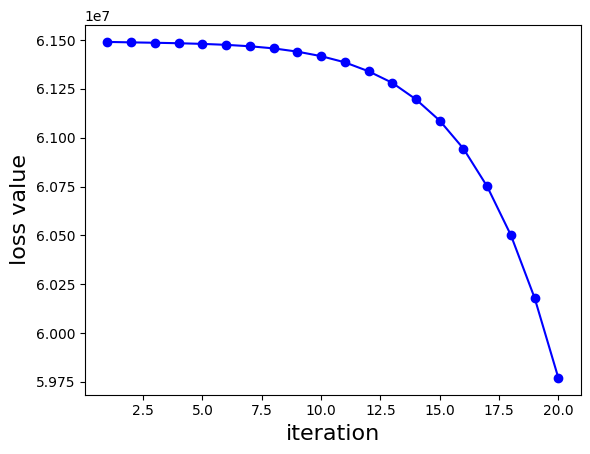

In [36]:
# initialize and train model
model = modelsppi.model_initialize(**config)
model.train(train, val, test)

### **Protein to Protein Sequence Similarity**

In [40]:
# Get the fasta (protein sequence data) from https://www.uniprot.org/help/downloads

!wget -P /content https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot_varsplic.fasta.gz

--2023-05-09 16:44:05--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot_varsplic.fasta.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8489379 (8.1M) [application/x-gzip]
Saving to: ‘/content/uniprot_sprot_varsplic.fasta.gz’

uniprot_sprot_varsp 100%[===================>]   8.10M   167KB/s    in 77s     

2023-05-09 16:45:23 (108 KB/s) - ‘/content/uniprot_sprot_varsplic.fasta.gz’ saved [8489379/8489379]



In [41]:
# extract/unzip the file

!gunzip /content/uniprot_sprot_varsplic.fasta.gz

In [42]:
# set the fasta file path

seq_path = '/content/uniprot_sprot_varsplic.fasta'

In [95]:
# Read and extract protein records using Bio library

seq_records = list(SeqIO.parse(seq_path, 'fasta'))

In [96]:
len(seq_records)

# total records 40,957, possible pairs 40,957 x 40,957 = 1,677,475,849
# Since the dataset is too big we will only use first 200 samples

40957

In [99]:
# Read and extract protein records using Bio library

seq_records = list(SeqIO.parse(seq_path, 'fasta'))[:200]

In [100]:
# Extract Sequence Pair
seqs = []
for i in range(len(seq_records)):
  seqs.append(str(seq_records[i].seq))

In [101]:
# Encode the protein sequence pair using DeepPurpose protein encoders

X = utils.encode_protein(pd.DataFrame(seq, columns=['Target Sequence']), 'AAC')

encoding protein...
unique target sequence: 95
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.


In [102]:
X

,Target Sequence,target_encoding
0,MENERAKQVYLAKLNEQAERYDEMVEAMKKVAALDVELTIEERNLL...,"[10.373, 5.809, 4.149, 5.809, 0.83, 12.033, 2...."
1,MENERAKQVYLAKLNEQAERYDEMVEAMKKVAALDVELTIEERNLL...,"[9.804, 5.49, 4.706, 5.882, 0.784, 12.157, 3.1..."
2,MSTREENVYMAKLAEQAERYEEMVEFMEKVAKTVDVEELSVEERNL...,"[11.417, 4.724, 3.15, 5.906, 0.787, 12.598, 1...."
3,MAATLGRDQYVYMAKLAEQAERYEEMVQFMEQLVTGATPAEELTVE...,"[10.623, 4.396, 2.93, 5.495, 1.099, 9.89, 3.66..."
4,MATTLSRDQYVYMAKLAEQAERYEEMVQFMEQLVSGATPAGELTVE...,"[10.976, 4.878, 2.439, 5.285, 0.813, 10.976, 3..."
...,...,...
94,MDPEPTEHSTDGVSVPRQPPSAQTGLDVQVVSAAGDSGTMSQDTEV...,"[7.434, 4.602, 3.894, 6.018, 0.354, 6.018, 5.1..."
95,MIGARVFCITTTALRRSPIFFFPKIPTRPVFRLSPATRPIVAMSTT...,"[6.542, 7.477, 3.738, 6.075, 2.336, 5.14, 4.20..."
96,MQFLKSAKQKPNYYHIMLVEDQEEGTLHQFNYCERCSESQNNKCIS...,"[5.426, 3.101, 4.91, 4.134, 3.876, 4.393, 5.16..."
97,MFQAAVGPLQTNISLPEETPGLELNWAALLIVMVIIPTIGGNILVI...,"[5.693, 4.95, 5.198, 2.475, 1.98, 4.455, 4.455..."


In [103]:
# Convert the target encoding to a tensor
X_tensor = torch.tensor(X['target_encoding'].values.tolist(), dtype=torch.float)

In [104]:
# Instantiate the similarity scoring model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(16840, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

In [105]:
# Define the optimization algorithm and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [106]:
# Train the model on a pair of protein sequences
x1 = X_tensor[0].unsqueeze(0)
x2 = X_tensor[1].unsqueeze(0)
y = torch.tensor([[0.8]], dtype=torch.float)

In [107]:
losses = []

for epoch in range(50):
    optimizer.zero_grad()
    
    # Concatenate x1 and x2 along the column axis
    x = torch.cat((x1, x2), dim=1)
    
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    print('Epoch {}: Loss = {:.4f}'.format(epoch+1, loss.item()))

Epoch 1: Loss = 0.0703
Epoch 2: Loss = 0.0190
Epoch 3: Loss = 0.0000
Epoch 4: Loss = 0.0069
Epoch 5: Loss = 0.0133
Epoch 6: Loss = 0.0152
Epoch 7: Loss = 0.0139
Epoch 8: Loss = 0.0103
Epoch 9: Loss = 0.0052
Epoch 10: Loss = 0.0011
Epoch 11: Loss = 0.0003
Epoch 12: Loss = 0.0041
Epoch 13: Loss = 0.0060
Epoch 14: Loss = 0.0037
Epoch 15: Loss = 0.0009
Epoch 16: Loss = 0.0000
Epoch 17: Loss = 0.0008
Epoch 18: Loss = 0.0020
Epoch 19: Loss = 0.0027
Epoch 20: Loss = 0.0026
Epoch 21: Loss = 0.0018
Epoch 22: Loss = 0.0008
Epoch 23: Loss = 0.0001
Epoch 24: Loss = 0.0002
Epoch 25: Loss = 0.0009
Epoch 26: Loss = 0.0013
Epoch 27: Loss = 0.0010
Epoch 28: Loss = 0.0004
Epoch 29: Loss = 0.0000
Epoch 30: Loss = 0.0000
Epoch 31: Loss = 0.0003
Epoch 32: Loss = 0.0005
Epoch 33: Loss = 0.0006
Epoch 34: Loss = 0.0004
Epoch 35: Loss = 0.0002
Epoch 36: Loss = 0.0000
Epoch 37: Loss = 0.0000
Epoch 38: Loss = 0.0002
Epoch 39: Loss = 0.0003
Epoch 40: Loss = 0.0003
Epoch 41: Loss = 0.0002
Epoch 42: Loss = 0.0000
E

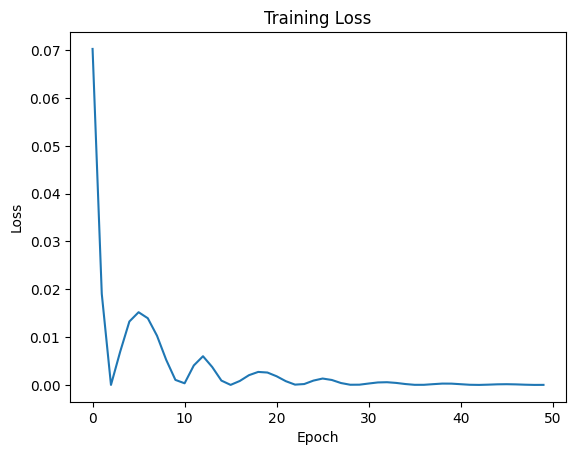

In [110]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [108]:
# Calculate the similarity score for the pair of protein sequences
score = model(torch.cat((x1, x2), dim=1)).item()
print('Similarity score: {:.4f}'.format(score))

Similarity score: 0.7929


##### The scores can be verified using NCBI Blast: https://blast.ncbi.nlm.nih.gov/Blast.cgi

##### NCBI BLAST (Basic Local Alignment Search Tool) is a widely used algorithm developed and maintained by the National Center for Biotechnology Information (NCBI) for comparing and analyzing biological sequences, such as DNA, RNA, and protein sequences.

##### Blast can provide alignment scores, if the two proteins are aligned.

##### Blast can be access via web interface or using python library


##### Using python library is very slow if verifying large dataset of protein to protein pairwise similarity sequence as the api has a limit of 15 seconds wait after each protein to protein pair request. Each request response takes approximately 30 seconds. For example sending a api request for 200 protein pairs can take approximately 1.5 to 2 hours

In [ ]:
# example of sending request to NCBI Blast API. 
# the code is commented because its extremely slow.


In [67]:
# # get the sequences
# x1_seq = Seq(X['Target Sequence'][0])
# x1_rec = SeqRecord(x1_seq, id="x1")

# x2_seq = Seq(X['Target Sequence'][1])
# x2_rec = SeqRecord(x2_seq, id="x2")

# # Perform BLAST search against NCBI database
# result_handle = NCBIWWW.qblast("blastp", "nr", [x1_seq, x2_seq])

# # Parse BLAST results
# blast_records = NCBIXML.parse(result_handle)

# # Iterate over each BLAST record and extract the alignments
# for record in blast_records:
#     query_id = record.query.split()[0]
#     for alignment in record.alignments:
#         for hsp in alignment.hsps:
#             print(f"Query: {query_id}")
#             print(f"Hit: {alignment.title}")
#             print(f"Alignment length: {hsp.align_length}")
#             print(f"Score: {hsp.score}")
#             print(hsp.query)
#             print(hsp.match)
#             print(hsp.sbjct)
#             print("\n")

#### Manually checking NCBI Blast to verify the similarity score generated by our model

---



In [69]:
# get the sequence

In [68]:
X['Target Sequence'][0]

'MENERAKQVYLAKLNEQAERYDEMVEAMKKVAALDVELTIEERNLLSVGYKNVIGARRASWRILSSIEQKEESKGNEQNAKRIKDYRTKVEEELSKICYDILAVIDKHLVPFATSGESTVFYYKMKGDYFRYLAEFKSGADREEAADLSLKAYEAATSSASTELSTTHPIRLGLALNFSVFYYEILNSPERACHLAKRAFDEAIAELDSLNEDSYKDSTLIMQLLRDNLTLWTSDLEEGGK'

In [72]:
X['Target Sequence'][1]

'MENERAKQVYLAKLNEQAERYDEMVEAMKKVAALDVELTIEERNLLSVGYKNVIGARRASWRILSSIEQKEESKGNEQNAKRIKDYRTKVEEELSKICYDILAVIDKHLVPFATSGESTVFYYKMKGDYFRYLAEFKSGADREEAADLSLKAYEAATSSASTELSTTHPIRLGLALNFSVFYYEILNSPERACHLAKRAFDEAIAELDSLNEDSYKDSTLIMQLLRDNLTLWTSDLEEGGEQSKGHNQQDEVNKI'

#### Enter the Sequence in the NCBI Blast search interface:

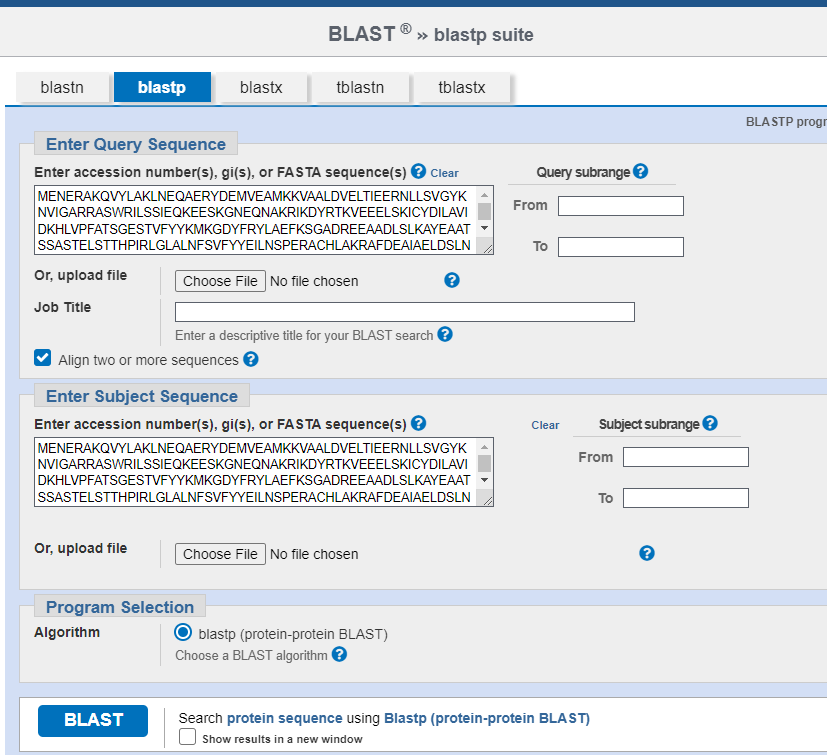

#### Get the Result

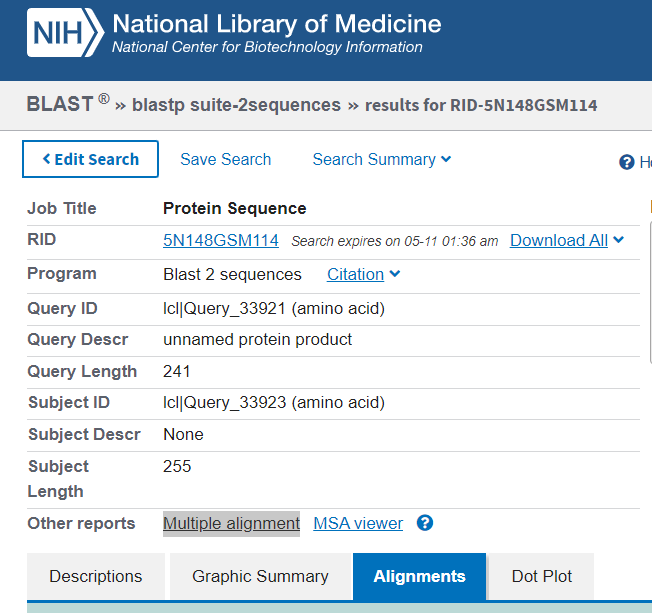


#### Analyze the Result

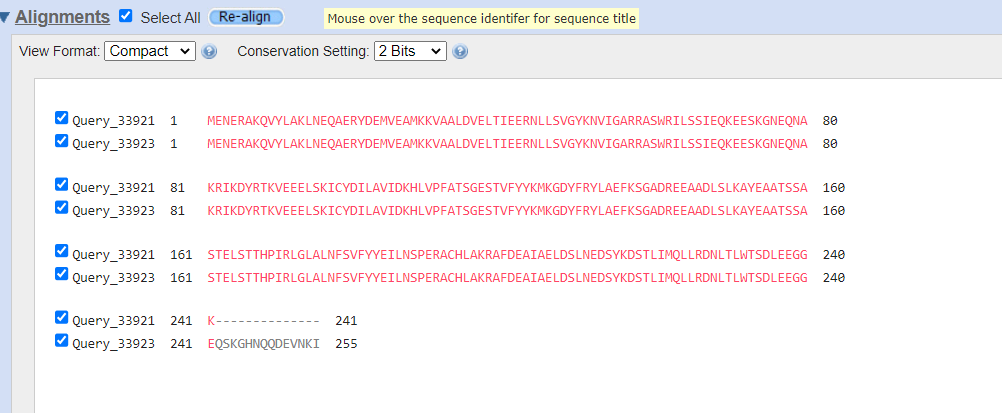

#### Our model predicted the similarity score of 0.7929

#### The NCBI Blast database score is 241/255 = 0.9450

#### Our model did very good. The model can be improved by experimenting with increasing epochs or changing the model hyper parameters or using different DeepPurpose available encoders

### Example of using multiprocessing to calulcate scores for all the protein pair sequences from uniprot fasta file

In [87]:
from multiprocessing import Pool
import numpy as np

# Define a function to calculate similarity scores for a pair of sequences
def calculate_score(x1, x2):
    score = model(torch.cat((x1, x2), dim=1)).item()
    return score

In [88]:
# Define a function to calculate similarity scores for all pairs of sequences
def calculate_all_scores(X_tensor):
    scores = np.zeros((len(X_tensor), len(X_tensor)))
    for i in range(len(X_tensor)):
        for j in range(i+1, len(X_tensor)):
            x1 = X_tensor[i].unsqueeze(0)
            x2 = X_tensor[j].unsqueeze(0)
            score = calculate_score(x1, x2)
            scores[i][j] = score
            scores[j][i] = score
    return scores

In [91]:
# Split the tensor into smaller batches for parallel processing
batch_size = 10
X_batches = torch.split(X_tensor, batch_size)

In [ ]:
# Instantiate a pool of worker processes
with Pool() as p:
    # Calculate similarity scores for each batch in parallel
    scores_batches = p.map(calculate_all_scores, X_batches)

In [ ]:
# Concatenate the scores from all batches into a single matrix
scores = np.concatenate(scores_batches)

In [ ]:
print(scores)